# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [62]:
region = [0, 100e3, 0, 150e3]
height = 1
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(40, 40), extra_coords=height)]
x, y, z = coordinates
prism = [40e3, 50e3, 60e3, 70e3, -10e3, 0]
density = 100
center = [(prism[1] + prism[0]) / 2, (prism[3] + prism[2]) / 2, (prism[5] + prism[4]) / 2]
print(center)
base_level = 3
gravity = hm.prism_gravity(coordinates, prism, density, field="g_z") + base_level
delta = 1
xderiv = (
    hm.prism_gravity((x + delta, y, z), prism, density, field="g_z")
    - hm.prism_gravity((x - delta, y, z), prism, density, field="g_z")
) / 2 * delta
yderiv = (
    hm.prism_gravity((x, y + delta, z), prism, density, field="g_z")
    - hm.prism_gravity((x, y - delta, z), prism, density, field="g_z")
) / 2 * delta
zderiv = (
    hm.prism_gravity((x, y, z + delta), prism, density, field="g_z")
    - hm.prism_gravity((x, y, z - delta), prism, density, field="g_z")
) / 2 * delta


gravity += random.normal(loc=0, scale=0.2, size=gravity.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

[45000.0, 65000.0, -5000.0]


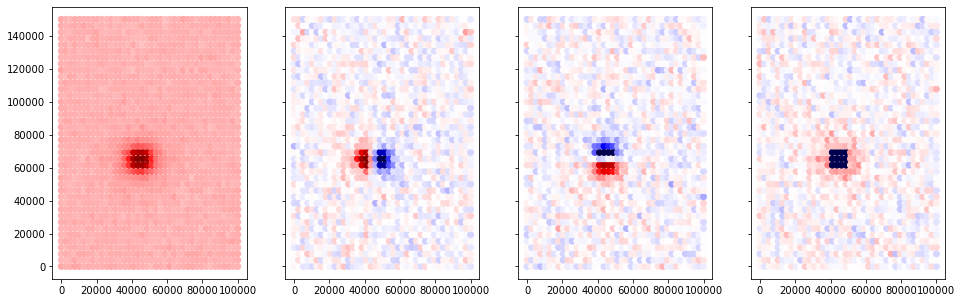

In [63]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
ax.scatter(x, y, c=gravity, cmap=cmap, vmin=-20, vmax=20)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)

## Calculate the matrices involved

In [64]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [65]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [66]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [125]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, Wp, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)    
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = sparse.linalg.inv(B @ Wd_inv @ B.T)
    ATQ = A.T @ Q
    BTQ = B.T @ Q
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A + Wp,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [146]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, step_data, step_params, maxit=100, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    parameters = np.array([
        coordinates[0].min(),
        coordinates[1].min(),
        0,
        0,
    ])
    data_predicted = np.zeros_like(data_observed)
    #data_predicted = np.copy(data_observed)
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)**2),
        np.full_like(field, 1 / np.linalg.norm(xderiv)**2),
        np.full_like(field, 1 / np.linalg.norm(yderiv)**2),
        np.full_like(field, 1 / np.linalg.norm(zderiv)**2),
    ])
    #wd = np.ones_like(data_observed)
    wp = np.ones_like(parameters)
    #for i in range(3):
    #    wp[i] =  np.linalg.norm(field)**2 / np.mean(coordinates[0]) ** 2
    print("Data weights:", wd)
    print("Parameter weights:", wp)
    Wd_inv = sparse.diags(1 / (step_data * wd), format="csc")
    Wp = sparse.diags(step_params * wp, format="csc")
    misfit = np.linalg.norm(eulers_equation(*coordinates, data_observed, parameters, structural_index))
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters, data_predicted, coordinates, data_observed, Wd_inv, Wp, structural_index,
        )
        parameters += deltap
        data_predicted += deltad
        new_misfit = np.linalg.norm(eulers_equation(*coordinates, data_observed, parameters, structural_index))
        print("delta_p:", deltap, "| misfit: {:.2f}".format(new_misfit))
        if (new_misfit > misfit) or (np.abs(misfit - new_misfit) / misfit < tol):
            break
        misfit = new_misfit
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data_predicted, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [155]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=2, 
    step_params=1e-1, 
    step_data=1,
    maxit=100,
    tol=1e-5,
)

Data weights: [5.12068156e-05 5.12068156e-05 5.12068156e-05 ... 5.22375950e+03
 5.22375950e+03 5.22375950e+03]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.         0.         0.         0.42520077] | misfit: 684.80
delta_p: [ 5.12099378e-06  6.15650605e-06 -8.77292037e-06  3.67083559e-01] | misfit: 677.08
delta_p: [ 6.68168604e-06  7.96737542e-06 -8.66934150e-06  3.16909913e-01] | misfit: 671.38
delta_p: [ 7.84226287e-06  9.32688260e-06 -8.57994637e-06  2.73594092e-01] | misfit: 667.20
delta_p: [ 8.70498660e-06  1.03486373e-05 -8.50278958e-06  2.36198756e-01] | misfit: 664.15
delta_p: [ 9.34602597e-06  1.11174985e-05 -8.43619336e-06  2.03914682e-01] | misfit: 661.93
delta_p: [ 9.82210843e-06  1.16968720e-05 -8.37871055e-06  1.76043254e-01] | misfit: 660.34
delta_p: [ 1.01754773e-05  1.21341519e-05 -8.32909273e-06  1.51981343e-01] | misfit: 659.21
delta_p: [ 1.04375856e-05  1.24647803e-05 -8.28626283e-06  1.31208259e-01] | misfit: 658.41
delta_p: [ 1.06318484e-05  1.27152749e-05 -8.249

In [156]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

0.0 0.0 -0.0 2.9
45000.0 65000.0 -5000.0 3.0


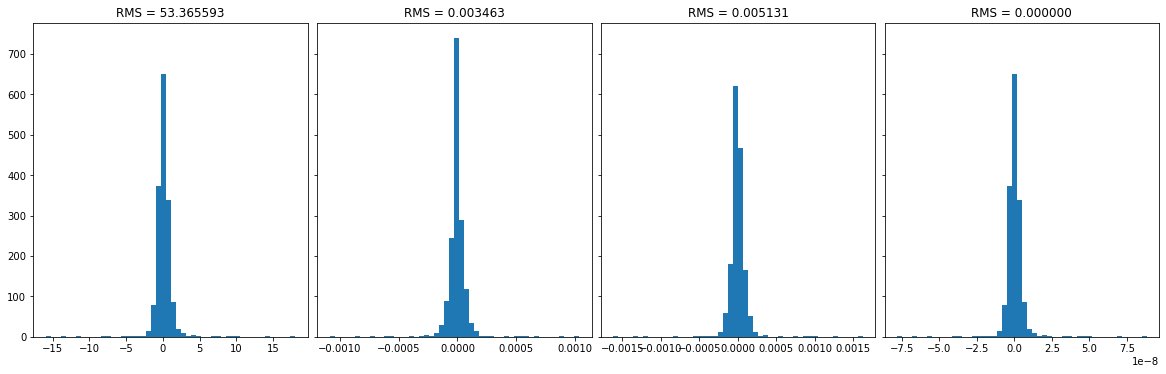

In [157]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

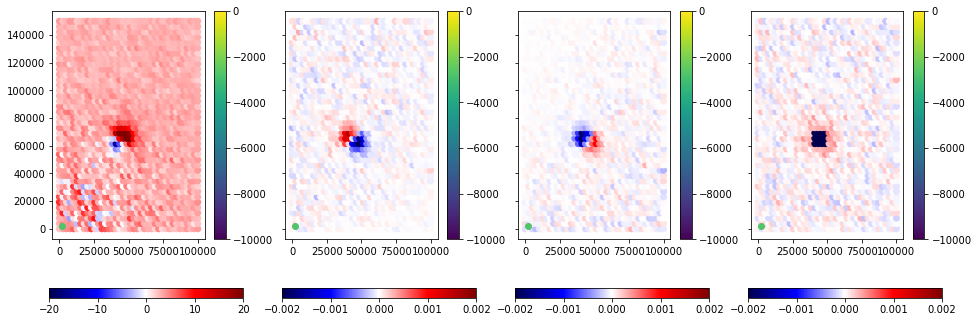

In [151]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.scatter(x, y, c=h, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

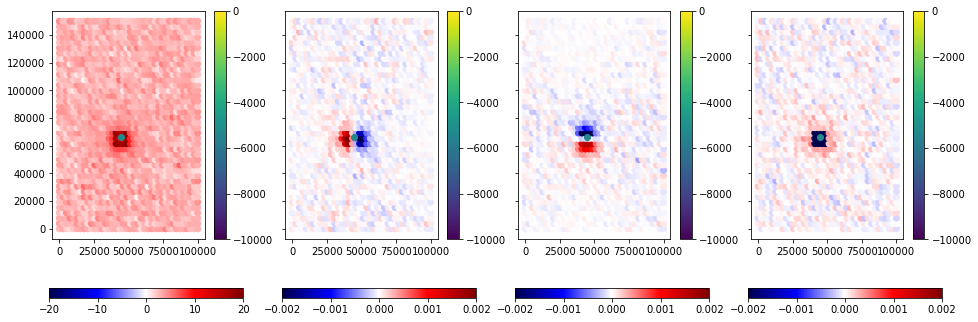

In [121]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.scatter(x, y, c=h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [111]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3, 
    step_params=1e-10, 
    step_data=1e0,
    maxit=100,
    tol=1e-5,
)

Data weights: [5.12068156e-05 5.12068156e-05 5.12068156e-05 ... 5.22375950e+03
 5.22375950e+03 5.22375950e+03]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.         0.         0.         3.13074314] | misfit: 661.63
delta_p: [ 1.20734184e+04  1.67556469e+04 -4.88078995e+03 -1.18612223e-02] | misfit: 517.43
delta_p: [ 1.16419993e+04  1.70128836e+04 -1.42066357e+03 -5.76371948e-03] | misfit: 384.50
delta_p: [ 1.05928156e+04  1.64080749e+04 -1.82861072e+03 -2.10053565e-02] | misfit: 280.01
delta_p: [ 6.09234345e+03  9.82090395e+03 -1.53743214e+02 -1.00392468e-02] | misfit: 238.88
delta_p: [ 2.51238351e+03  4.11280817e+03 -1.76399377e+02  1.19366548e-03] | misfit: 229.49
delta_p: [ 1.07846794e+03  1.75800250e+03 -7.89704378e+01  1.73584875e-03] | misfit: 227.11
delta_p: [ 4.57702719e+02  7.56039820e+02 -5.58838803e+01  6.88023676e-04] | misfit: 226.43
delta_p: [ 1.94761278e+02  3.26484126e+02 -2.93443593e+01  2.78965081e-04] | misfit: 226.20
delta_p: [ 8.27919455e+01  1.41553808e+02 -1.515

In [112]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

44787.1 67199.6 -8652.8 3.1
45000.0 65000.0 -5000.0 3.0


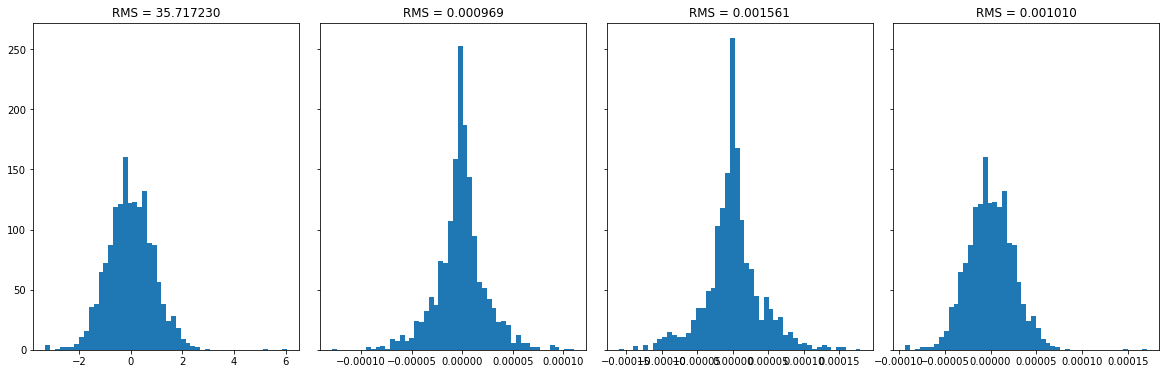

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

In [114]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1, 
    step_params=1e-10, 
    step_data=1e0,
    maxit=100,
    tol=1e-5,
)

Data weights: [5.12068156e-05 5.12068156e-05 5.12068156e-05 ... 5.22375950e+03
 5.22375950e+03 5.22375950e+03]
Parameter weights: [1. 1. 1. 1.]
delta_p: [0.        0.        0.        3.0811673] | misfit: 656.90
delta_p: [4.20605782e+03 4.86268644e+03 7.26350220e+02 5.15192362e-03] | misfit: 611.54
delta_p: [ 3.47510723e+03  4.41678013e+03 -1.39927437e+02  1.41072520e-02] | misfit: 572.62
delta_p: [ 3.66010644e+03  4.44510435e+03  3.14637269e+02 -1.35703436e-03] | misfit: 533.14
delta_p: [ 3.63173501e+03  4.79903686e+03 -3.59206401e+02 -3.16941704e-03] | misfit: 492.62
delta_p: [ 3.90938296e+03  5.19859592e+03 -1.10793741e+02 -6.83572095e-03] | misfit: 449.68
delta_p: [ 4.10860091e+03  6.00586009e+03 -6.70787033e+02 -2.42053928e-02] | misfit: 403.19
delta_p: [ 4.83941669e+03  7.40110945e+03 -5.55823249e+02 -5.45731914e-02] | misfit: 349.57
delta_p: [ 6.60825520e+03  1.09308632e+04 -9.77107793e+02 -1.20558523e-01] | misfit: 281.79
delta_p: [ 8.34465380e+03  1.44022951e+04 -4.39909330e+0

In [115]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

44862.9 66350.8 -1956.3 2.2
45000.0 65000.0 -5000.0 3.0


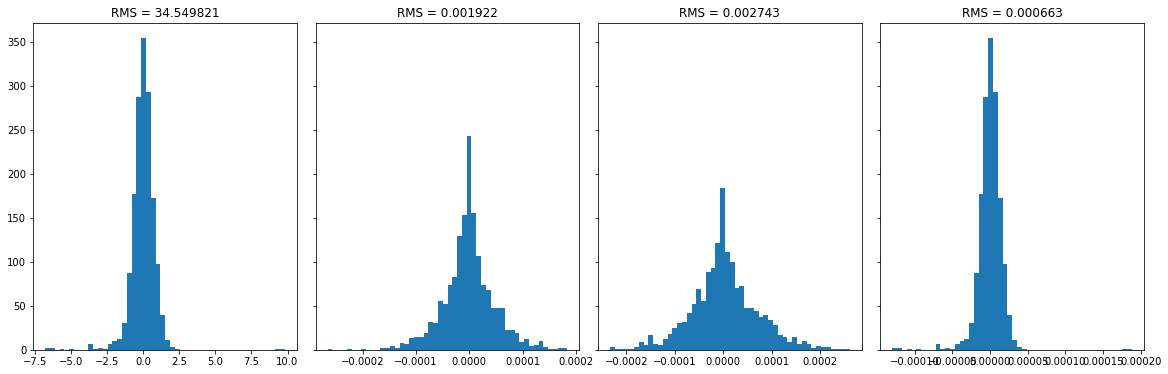

In [116]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)